In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Feb 15 12:10:56 2023

@author: earxzho
"""
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr
import scipy.stats as stats
import seaborn as sns
import matplotlib
from matplotlib import cm
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib import gridspec

In [4]:
params = {'legend.fontsize':12,
         'axes.labelsize':17,
         'axes.titlesize':22,
         'xtick.labelsize':15,
         'ytick.labelsize':15}
plt.rcParams.update(params)

In [15]:
# ---------------------------------------------------------------------------------------------------
def plot_press_time(ax, var_xr,levelsInput,contourLevels,Dates,plev,p_xr):
    # define color map
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    cs2= var_xr.plot.contourf(x='time',y='plev',levels=levelsInput,yscale = 'log',yincrease=False,\
        ax=ax,cmap=cmap,extend="both",add_colorbar=False)
    contour=var_xr.plot.contour(x="time",y="plev",yscale = 'log',yincrease=False,\
            ax=ax,levels=contourLevels,linestyles=':',linewidths=0.8,colors='k',extend='both') 
    if np.max(contourLevels) < 0.1:
        plt.clabel(contour,contour.levels[:-1],fontsize=10,inline=1,fmt='%0.2f',zorder =10,use_clabeltext=True)
        plt.clabel(contour, [1], fontsize=10,inline=0,fmt='%0.0f',zorder =10,use_clabeltext=True)
    else:
        plt.clabel(contour,fontsize=10,inline=1,fmt='%0.0f',zorder = 10,use_clabeltext=True)
    c1b=p_xr.plot.contourf(x="time",y="plev",levels=[np.min(p_xr),0.1,np.max(p_xr)],zorder=1,hatches=['..',None],colors="none",extend="neither",ax=ax,add_colorbar=False) 
    # ------------------------------
    # New bit here that handles changing the color of hatches
    colors = ['grey', 'none']
    # For each level, we set the color of its hatch 
    for i, collection in enumerate(c1b.collections):
        collection.set_edgecolor(colors[i % len(colors)])
    # Doing this also colors in the box around each level
    # We can remove the colored line around the levels by setting the linewidth to 0
    for collection in c1b.collections:
        collection.set_linewidth(0)
    # ------------------------------
    ax.set_ylabel('pressure [hPa]')#, fontsize=15)
    ax.invert_yaxis()
    ax.set_ylim([110,10])
    ax.set_xlabel('time')#, fontsize=15)
    ax.axhline(y=100,color="grey", linestyle="--",zorder=1)

    plt.grid(False)   
    return cs2
#-------------------------------------------------------------------------------------------

In [39]:
pathMyDirectory="/nfs/b0140/Users/earxzho/VOLMIP/data/" 
os.chdir(pathMyDirectory)
# read file
meanT=xr.open_dataset(pathMyDirectory+'/temp_tropics_ensMean_control_monthly.nc').temp_mean
stdT=np.squeeze(xr.open_dataset(pathMyDirectory+'/temp_tropics_ensStd_control_monthly.nc').temp_stdev)
meanT2=xr.open_dataset(pathMyDirectory+'/temp_tropics_ensMean_volmip_monthly.nc').temp_mean
stdT2=np.squeeze(xr.open_dataset(pathMyDirectory+'/temp_tropics_ensStd_volmip_monthly.nc').temp_stdev)

# Student-t test for the two samples
N1=27
N2=27
significance = 0.05

# significance for Temperature
t_temp,p_temp=stats.ttest_ind_from_stats(meanT,stdT,N1,meanT2,stdT2,N2)
p_temp_xr = xr.DataArray(p_temp,dims=meanT.dims,coords=meanT.coords)


##
# Read omega
ds1=xr.open_dataset(pathMyDirectory+"wstar_ens_control_monthly.nc")
ds2=xr.open_dataset(pathMyDirectory+"wstar_ens_volmip_monthly.nc")
factor=10**3
## peak value averaged at 1992OND at 100hPa
itime = 22
ilevel =10
dssm1 = ds1['wstar'].rolling(time=3, center=True).mean().isel(time=itime,plev=ilevel).sel(lat=slice(-10,10)).mean('lat')*factor
dssm2 = ds2['wstar'].rolling(time=3, center=True).mean().isel(time=itime,plev=ilevel).sel(lat=slice(-10,10)).mean('lat')*factor

cptt = xr.open_dataset(pathMyDirectory+"/cptt_tropics5_control_monthly.nc")['temp']
cptt_vol = xr.open_dataset(pathMyDirectory+"/cptt_tropics5_volmip_monthly.nc")['temp']

##group by ENSO & NAO phases
## group by different ENSO & NAO phases
# Ensemble for +NAO/0NAO/-NAO
omega_naop = (dssm2 - dssm1).isel(realization=slice(0,9))
omega_nao0 = (dssm2 - dssm1).isel(realization=slice(9,18))
omega_naon = (dssm2 - dssm1).isel(realization=slice(18,27))

cptt_naop = (cptt_vol - cptt).isel(realization=slice(0,9))
cptt_nao0 = (cptt_vol - cptt).isel(realization=slice(9,18))
cptt_naon = (cptt_vol - cptt).isel(realization=slice(18,27))

# group by ENSO phases
list_enso = np.array_split(np.arange(27),9)
i_ensop = np.array(list_enso)[0::3,:].flatten()
i_enso0 = np.array(list_enso)[1::3,:].flatten()
i_enson = np.array(list_enso)[2::3,:].flatten()

omega_ensop = (dssm2 - dssm1).isel(realization = i_ensop)
omega_enso0 = (dssm2 - dssm1).isel(realization = i_enso0)
omega_enson = (dssm2 - dssm1).isel(realization = i_enson)

cptt_ensop = (cptt_vol - cptt).isel(realization = i_ensop)
cptt_enso0 = (cptt_vol - cptt).isel(realization = i_enso0)
cptt_enson = (cptt_vol - cptt).isel(realization = i_enson)

cptt_peak = [cptt_ensop,cptt_enso0,cptt_enson,
             cptt_naop,cptt_nao0,cptt_naon]
omega_peak = [omega_ensop,omega_enso0,omega_enson,
              omega_naop,omega_nao0,omega_naon]

## For omega profiles 
NT_band = xr.open_dataset(pathMyDirectory+'wstar_NTband_diffmean_monthly.nc')['wstar']
NT_std = xr.open_dataset(pathMyDirectory+'wstar_NTband_std_monthly.nc')['wstar']
ST_band = xr.open_dataset(pathMyDirectory+'wstar_STband_diffmean_monthly.nc')['wstar']
ST_std = xr.open_dataset(pathMyDirectory+'wstar_STband_std_monthly.nc')['wstar']


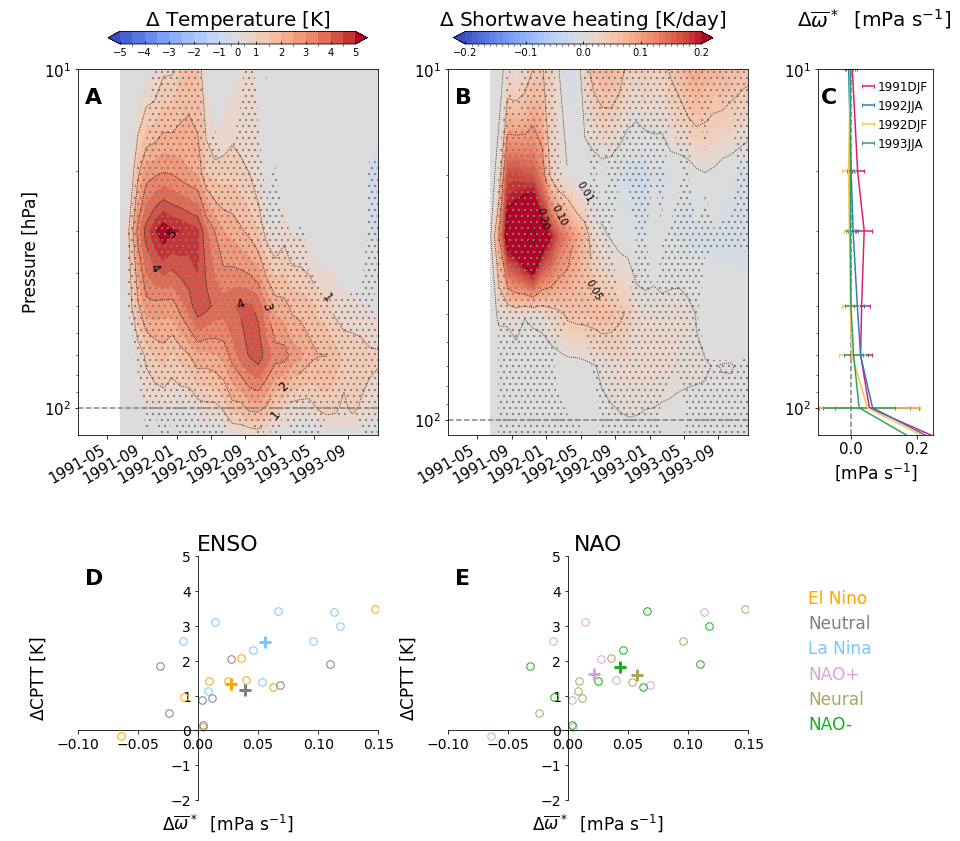

In [40]:
#####################################################################################################################
niceDates=[]

for i in range(np.shape(meanT.time)[0]):
    niceDates.append(datetime.date(int(str(meanT.time.values[i])[0:4]),int(str(meanT.time.values[i])[5:7]),int(str(meanT.time.values[i])[8:10])))
#*********************************************************************
# plot temperature pressure-time cross section
#plot difference between the two runs
fig = plt.figure(figsize=[6,7])
cmapJet= sns.color_palette("coolwarm", as_cmap=True)
vminJet=-5
vmaxJet=5.5
levelsInput=np.arange(vminJet,vmaxJet,0.5)
levelsInput = np.delete(levelsInput,[10])
# normPlot2=matplotlib.colors.SymLogNorm(vmin=vminJet,vmax=vmaxJet,linthresh=0.1)#0.1

# timeIdx,levIdx=significantArray.nonzero()
startP=5
stopP=15
plev=meanT.plev[startP:stopP]
deltaT = meanT2[:,startP:stopP]-meanT[:,startP:stopP]
deltaT[0:5,:]= np.NAN

# ax2 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(2,5,(1,2))
cs2 = xr.plot.contourf(deltaT.T,levels=levelsInput,yscale='log',ylim=[110,10],add_colorbar=False,ax=ax2,cmap=cmapJet,extend='both')
contour=ax2.contour(niceDates[:],plev,(meanT2[:,startP:stopP]-meanT[:,startP:stopP]).T,\
            [1,2,3,4,5],linestyles=':',linewidths=0.8,colors='k')
plt.clabel(contour,fontsize=12,inline=1,fmt='%0.0f')
ax2.tick_params(axis='both', which='major')#, labelsize=10)
c1b=p_temp_xr.squeeze().T.plot.contourf(levels=[np.min(p_temp),0.1,np.max(p_temp)],zorder=1,hatches=['..',None],colors="none",ax=ax2,add_colorbar=False) 
# ------------------------------
# New bit here that handles changing the color of hatches
colors = ['grey', 'none']
# For each level, we set the color of its hatch 
for i, collection in enumerate(c1b.collections):
    collection.set_edgecolor(colors[i % len(colors)])
# Doing this also colors in the box around each level
# We can remove the colored line around the levels by setting the linewidth to 0
for collection in c1b.collections:
    collection.set_linewidth(0)
# ------------------------------

ax2.axhline(y=100,color="grey", linestyle="--")

ax2.set_ylabel('Pressure [hPa]')#, fontsize=labelsizes)
ax2.invert_yaxis()
ax2.set_ylim([120,min(plev)])
#     ax2.text(datetime.date(1991,2,15), 55,'Volcanic  \nForcing',fontsize=22)

ax2.set_xlabel('')#, fontsize=labelsizes)


##################################################################################################################
# plot b
# plot shortwave heating rate
vname='csswhr'
ds1=xr.open_dataset(pathMyDirectory+vname+"_tropics5_ens_control_monthly.nc")[vname].isel(realization=slice(1,26))
ds2=xr.open_dataset(pathMyDirectory+vname+"_tropics5_ens_volmip_monthly.nc")[vname].isel(realization=slice(1,26))
mean1 = ds1.mean('realization')
std1= ds1.std('realization')
mean2= ds2.mean('realization')
std2= ds2.std('realization')
sampleSize = 26
t,p = stats.ttest_ind_from_stats(mean1, std1, sampleSize, mean2, std2, sampleSize)
p_xr = xr.DataArray(p,dims=mean1.dims, coords=mean1.coords)

mean = mean2 - mean1
mean = mean*86400. #change unit from K/s to K/day

#plot
ax3 = fig.add_subplot(2,5,(3,4))
levelsInput = np.arange(-2,2.1,0.1)*0.1
levelsInput = np.delete(levelsInput,[20])
cs3 = mean.plot.contourf(x='time',y='plev',levels=levelsInput,yscale='log',yincrease=False,ylim=[110,10],add_colorbar=False,ax=ax3,cmap=cmapJet,extend='both')
contour=mean.plot.contour(x='time',y='plev',yscale='log',yincrease=False,ylim=[110,10],\
            levels=[0.01,0.05,0.1,0.2,0.3],linestyles=':',linewidths=0.8,colors='k')
plt.clabel(contour,fontsize=10,inline=1,fmt='%0.2f')
ax2.tick_params(axis='both', which='major')#, labelsize=10)
c1b=p_xr.plot.contourf(x="time",y="plev",levels=[np.min(p_xr),0.1,np.max(p_xr)],zorder=1,hatches=['..',None],colors="none",extend="neither",ax=ax3,add_colorbar=False) 
#
# ------------------------------
# New bit here that handles changing the color of hatches
colors = ['grey', 'none']
# For each level, we set the color of its hatch 
for i, collection in enumerate(c1b.collections):
    collection.set_edgecolor(colors[i % len(colors)])
# Doing this also colors in the box around each level
# We can remove the colored line around the levels by setting the linewidth to 0
for collection in c1b.collections:
    collection.set_linewidth(0)
# ------------------------------

ax3.axhline(y=100,color="grey", linestyle="--")
ax3.set_ylabel('')
ax3.invert_yaxis()
ax3.set_xlabel('')

# Add color bar
plt.subplots_adjust(bottom=0.4, left=.01, right=1.99, top=1.85, wspace=.6,hspace=0.)
cbar_ax = plt.axes([0.08, 1.9, 0.6, 0.025])   # left,bottom,width,height
ticks = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
cb = fig.colorbar(cs2, cax=cbar_ax, ticks=ticks, orientation='horizontal',format=matplotlib.ticker.ScalarFormatter())
cb.ax.set_title("$\Delta$ Temperature [K]",fontsize=20)#,fontsize=labelsizes)
cb.ax.tick_params(labelsize=10,direction="in") 

cbar_ax = plt.axes([0.88, 1.9, 0.6, 0.025])   # left,bottom,width,height
ticks = [-0.2,-0.1,0,0.1,0.2]
cb = fig.colorbar(cs3, cax=cbar_ax, ticks=ticks, orientation='horizontal',format=matplotlib.ticker.ScalarFormatter())
cb.ax.set_title("$\Delta$ Shortwave heating [K/day]",fontsize=20)#,fontsize=labelsizes)
cb.ax.tick_params(labelsize=10,direction="in") 
#############################################################################################################################

# plot c
# plot W* profile
colors = ['#dd1c77','#2c7fb8','#fec44f','#2ca25f']
ax1 = fig.add_subplot(2,5,5,sharey=ax2)

for i , time in enumerate((12,19,24,29)):
    if time%12==0: #ODJ
        ax1.errorbar(ST_band.isel(time=time,plev=slice(startP,stopP)),plev,xerr=ST_std.isel(time=time,plev=slice(startP,stopP)),capsize=2,color=colors[i],\
                         label=str(ST_band.isel(time=time-1).time.values)[0:4]+'DJF')
    else:
        ax1.errorbar(NT_band.isel(time=time,plev=slice(startP,stopP)),plev,xerr=NT_std.isel(time=time,plev=slice(startP,stopP)),capsize=2,color=colors[i],\
                 label=str(NT_band.isel(time=time).time.values)[0:4]+'JJA')
ax1.set_xlim([-0.1,0.25])

ax1.set_xlabel('[mPa s$^{-1}$]')
ax1.set_title(r'$\Delta \overline{\omega}^*$  [mPa s$^{-1}$]'+' \n ',fontsize=20,y=1.04)

ax1.axvline(x=0,color='grey',linestyle='--')

leg = plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1), handlelength=0, frameon=False)
for line, text in zip(leg.get_lines(), leg.get_texts()):
   text.set_color(line.get_color())
#############################################################################################################################

# # plot d , e
ax4 = fig.add_subplot(3,5,(11,12))
ax5 = fig.add_subplot(3,5,(13,14))

ms = 7.5  # markersize
ylab = ['Europe', 'North Atlantic']


colors_enso=['#FFA500','#808080','#7BC8F6']
for i in range(3):
    ax4.plot(omega_peak[i], cptt_peak[i],
                linestyle='none', marker='o', color=colors_enso[i], markerfacecolor='None',
                markersize=ms)
    ax4.plot(omega_peak[i].mean('realization'), cptt_peak[i].mean('realization'),
                marker="+",markerfacecolor='None',color=colors_enso[i],  markeredgecolor=colors_enso[i], markersize=12, mew=3,zorder=10)   
                # linestyle='none', marker='o', color=color_mean,
                # markersize=ms)
    ax4.set_xlim([-0.1,0.15])
    ax4.set_ylim([-2,5])


colors_nao=['#DDA0DD','#AAA662','#15B01A']
for i in range(3,6):
    ax5.plot(omega_peak[i], cptt_peak[i],
                linestyle='none', marker='o', color=colors_nao[i-3],markerfacecolor='None',  
                markersize=ms)
    ax5.plot(omega_peak[i].mean('realization'), cptt_peak[i].mean('realization'),
                marker="+", color=colors_nao[i-3], markeredgecolor=colors_nao[i-3], markersize=12, mew=3,zorder=10)   
                # linestyle='none', marker='o', color=color_mean,
                # markersize=ms)
    ax5.set_xlim([-0.1,0.15])
    ax5.set_ylim([-2,5])

# labels
for ax in [ax4,ax5]:
    ax.set_xlabel(r'$\Delta \overline{\omega}^*$  [mPa s$^{-1}$]')
    ax.xaxis.set_label_coords(0.5, -0.05)
    ax.set_ylabel('\n$\Delta$CPTT [K]')#, fontsize=15)
    ax.yaxis.set_label_coords(-0.1, 0.5)


ax4.set_title("ENSO")
ax5.set_title('NAO')

for ax in [ax4,ax5]:
    ax.tick_params(labelsize=14)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    
    
# text for colors
fig.text(1.7, 0.8, 'El Nino', color=colors_enso[0], ha='left',
         va='center', fontsize=17)
fig.text(1.7, 0.75, 'Neutral', color=colors_enso[1], ha='left',
         va='center', fontsize=17)
fig.text(1.7, 0.7, 'La Nina', color=colors_enso[2], ha='left',
         va='center', fontsize=17)
fig.text(1.7, 0.65, 'NAO+', color=colors_nao[0], ha='left',
         va='center', fontsize=17)
fig.text(1.7, 0.6, 'Neural', color=colors_nao[1], ha='left',
         va='center', fontsize=17)
fig.text(1.7, 0.55, 'NAO-', color=colors_nao[2], ha='left',
         va='center', fontsize=17)

#########################################################################
# Label A ,B
for axs, label in zip([ax2,ax3,ax1,ax4,ax5],['A', 'B', 'C','D','E']):
    axs.text(0.025, 0.95, label, transform=axs.transAxes,
            fontsize=22, fontweight='bold', va='top')

plt.show()